# Declare DPP class(SLOW)

In [4]:
import numpy as np 
from scipy.spatial import distance 
import random as rd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
print("Packages Import")
rd_seed = 1
np.random.seed(rd_seed)
print("Set Random Seed: {}".format(rd_seed))

Packages Import
Set Random Seed: 1


In [5]:
def kernel_se(X1,X2,hyp={'gain':1,'len':1,'noise':1e-8}):
    hyp_gain       = float(hyp['gain'])**2
    hyp_len        = 1/float(hyp['len'])
    pairwise_dists = distance.cdist(X1,X2,'euclidean')
    K = hyp_gain*np.exp(-pairwise_dists ** 2 * (hyp_len**2))
    return K

def Kdpp(x, k):
    # Select _n samples out of _X using K-DPP
    n,d = x.shape[0],x.shape[1]
    mid_dist = np.median(distance.cdist(x, x,'euclidean'))
    out,idx  = np.zeros(shape=(k,d)),[]
    for i in range(k):
        if i == 0:
            # Pick Random Point at first
            rand_idx = np.random.randint(n)
            idx.append(rand_idx) # append index
            out[i,:] = x[rand_idx,:] # append  inputs
        else:
            # Pick Furtest point
            det_vals = np.zeros(n)
            for j in range(n):
                if j in idx:
                    det_vals[j] = -np.inf
                else:
                    idx_temp = idx.copy()
                    idx_temp.append(j)
                    X_curr = x[idx_temp,:]
                    K = kernel_se(X_curr,X_curr,{'gain':1,'len':mid_dist,'noise':1e-4}) # If mid_dist has error, change it to 1
                    det_vals[j] = np.linalg.det(K)

            max_idx = np.argmax(det_vals)
            idx.append(max_idx)
            out[i,:] = x[max_idx,:] # append  inputs
    return out,idx

In [6]:
x_data = np.random.uniform(-2, 2, (2000, 2))
k = 4
_, kidx = Kdpp(x=x_data, k=k) # Original Implementation is SLOW.

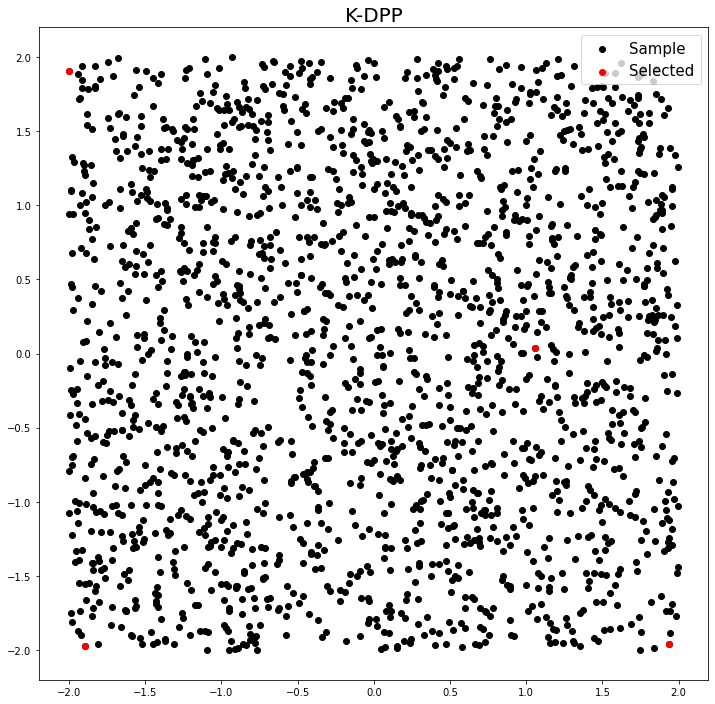

In [7]:
""" Plot """
plt.figure(figsize=(12,12))
plt.scatter(x_data[:,0], x_data[:,1], c='k', label="Sample")
plt.scatter(x_data[kidx,0], x_data[kidx,1], c='r', label="Selected")
plt.title("K-DPP", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Declare LA-DPP Class(FAST)

In [8]:
def get_median(x):
    D      = distance.cdist(x,x,'euclidean')
    K      = np.exp((D**2))
def LAdpp(x, k,k_gain = 1000):
    n      = x.shape[0]
    sum_K  = np.zeros((1,n))
    d      = x.shape[1]
    D      = distance.cdist(x,x,'euclidean')
    K      = np.exp(-k_gain*(D**2))
    K_     = 0.5*(K+K.T)
    selPoint = np.zeros(shape=(k, d))
    selIdx   = []
    sel_idx  = np.zeros(k)
    remain_idx = np.linspace(0, n-1, n, dtype=int).reshape(-1)

    for k_num in range(k):
        
        if k_num==0:
            # Pick Random Point at first
            rand_idx = np.random.randint(n)
            selIdx.append(rand_idx) # append index
            selPoint[k_num,:] = x[rand_idx,:] # append  inputs
            remain_idx = np.delete(remain_idx, rand_idx).reshape(-1)
        else: 
            # Pick Furtest point
            curr_K = K_[selIdx[k_num-1],:]
            sum_K = sum_K+curr_K
            k_val = sum_K[:, remain_idx]
            min_idx = np.argmin(k_val)
            sel_idx = remain_idx[min_idx]
            selIdx.append(sel_idx)
            remain_idx = np.delete(remain_idx, min_idx).reshape(-1)
            selPoint[k_num, :] = x[sel_idx,:] # append a selected point
    return selIdx

In [9]:
""" LA-DPP """
x_data = np.random.uniform(-2, 2, (2000, 2))
k = 4
selidx = LAdpp(x=x_data, k=k)
print(sorted(selidx))


[0, 1, 2, 47]


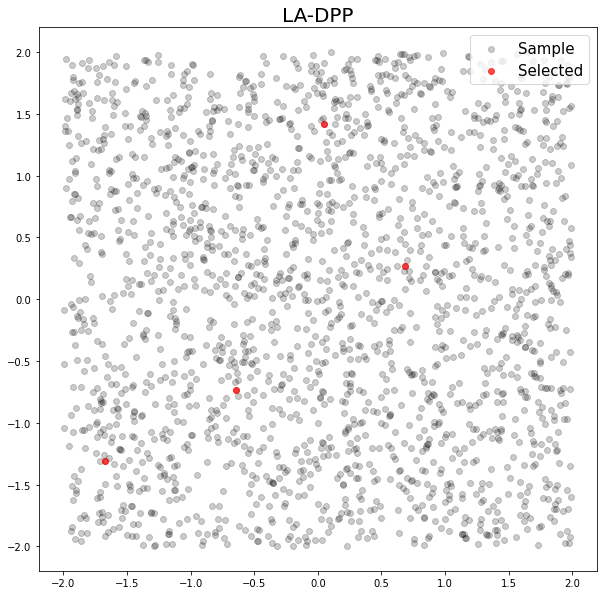

In [10]:
""" Plot """
plt.figure(figsize=(10,10))
plt.scatter(x_data[:,0], x_data[:,1], c='k', alpha=0.2, label="Sample")
plt.scatter(x_data[selidx,0], x_data[selidx,1], c='r', alpha=0.7, label="Selected")
plt.title("LA-DPP", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# CLIP Features

In [54]:
import clip
device = 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [62]:
from PIL import Image


import cv2
from pathlib import Path
imgFolderPath = Path("candidate")

images = []
rawimages =[]
for i,imgPath in enumerate(imgFolderPath.iterdir()):
    image = Image.open(imgPath)
    rawimages.append(image)
    image = clip_preprocess(image)
    image = image.numpy()
    images.append(image)
images = np.array(images)

imageTensor = torch.tensor(images).to(device)

In [57]:
inTensor = imageTensor

outTensor = clip_model.encode_image(imageTensor)

In [59]:
""" DPP """
np.random.seed(41)
features = outTensor.detach().numpy()
k = 10
_,selidx = Kdpp(x=features, k=k)
print(sorted(selidx))


[0, 4, 9, 14, 15, 21, 30, 34, 46, 51]


In [64]:
""" Save CLIP Selected images"""
import torchvision


savePath = Path("CLIPFeatures")
Path.mkdir(savePath,exist_ok=True)

for i,idx in enumerate(selidx):
    image = rawimages[idx]
    imagePath = savePath/ "image{}.png".format(i)
    image.save(imagePath)

# VGG Features

In [16]:
import cv2
from pathlib import Path
imgFolderPath = Path("candidate")

images = []
for i,imgPath in enumerate(imgFolderPath.iterdir()):
    image = cv2.imread(str(imgPath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(244,244,))
    images.append(image)
images = np.array(images)

In [18]:
import torch
imageTensor = torch.tensor(images)
imageTensor = imageTensor.permute((0,3,1,2))
imageTensor = imageTensor/255

(-0.5, 243.5, 243.5, -0.5)

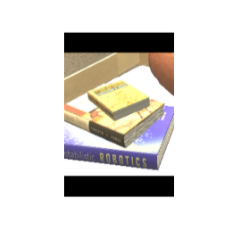

In [19]:
plt.imshow(images[15])
plt.axis('off')

In [166]:
import torchvision.models as models
import torch
vgg16 = models.vgg16()
vgg16.eval()
pass

In [208]:
# Normalize
MEAN,VAR = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

inTensor = imageTensor-MEAN[:,None,None]
inTensor = inTensor/VAR[:,None,None]

# VGG
outTensor = vgg16.features(inTensor)
outTensor = vgg16.avgpool(outTensor)
outTensor = torch.flatten(outTensor, 1)


TargetFCNumber,FCCounter = 2, 0

for layer in vgg16.classifier:
    outTensor = layer(outTensor)
    if isinstance(layer,torch.nn.Linear): FCCounter = FCCounter + 1
    if FCCounter == TargetFCNumber: break

    
outTensor.size()

torch.Size([61, 4096])

In [216]:
""" DPP """
np.random.seed(41)
features = outTensor.detach().numpy()
k = 10
_,selidx = Kdpp(x=features, k=k)
print(sorted(selidx))


[0, 6, 8, 9, 11, 15, 18, 38, 40, 55]


In [217]:
""" TSNE for plotting"""
from sklearn.manifold import TSNE
tsne_features = TSNE(n_components = 2).fit_transform(features)

/home/taerim/.pyenv/versions/3.9.10/envs/ai2thor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taerim/.pyenv/versions/3.9.10/envs/ai2thor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


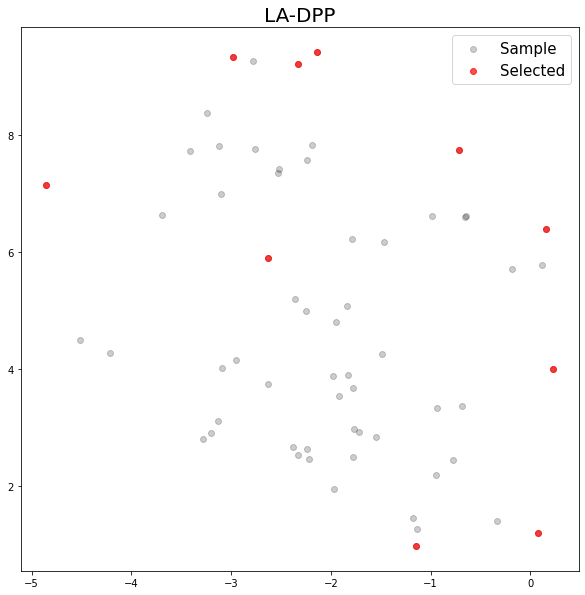

In [218]:
""" Plot """
plt.figure(figsize=(10,10))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c='k', alpha=0.2, label="Sample")
plt.scatter(tsne_features[selidx,0], tsne_features[selidx,1], c='r', alpha=0.7, label="Selected")
plt.title("LA-DPP", fontsize=20)
plt.legend(fontsize=15)
plt.show()

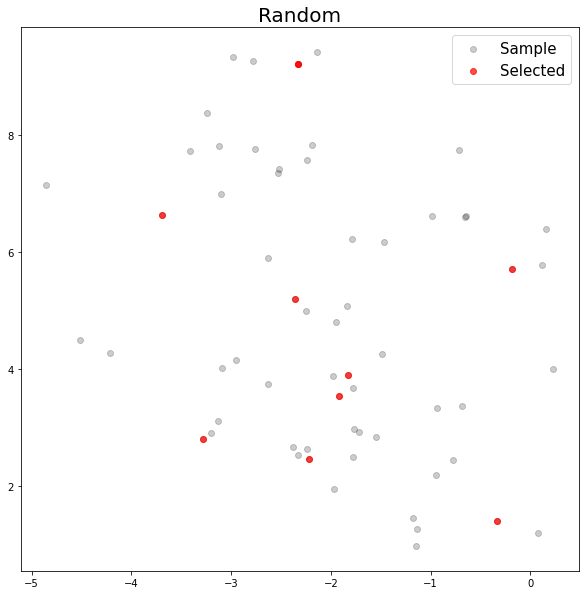

In [219]:
""" Random for comparison """
np.random.seed(42)
ranidx = np.random.randint(0,len(features),k)

plt.figure(figsize=(10,10))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c='k', alpha=0.2, label="Sample")
plt.scatter(tsne_features[ranidx,0], tsne_features[ranidx,1], c='r', alpha=0.7, label="Selected")
plt.title("Random", fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [220]:
""" Save Selected images"""
import torchvision
imageSelected = imageTensor[selidx]

savePath = Path("imageSelected")
Path.mkdir(savePath,exist_ok=True)

for i,image in enumerate(imageSelected):
    imagePath = savePath/ "image{}.png".format(i)
    torchvision.utils.save_image(image,imagePath)

In [221]:
""" Save Random images"""
import torchvision
imageRandom = imageTensor[ranidx]

savePath = Path("imageRandom")
Path.mkdir(savePath,exist_ok=True)

for i,image in enumerate(imageRandom):
    imagePath = savePath/ "image{}.png".format(i)
    torchvision.utils.save_image(image,imagePath)